In [1]:
import pandas as pd

In [2]:
df = pd.read_csv(r'D:\predictive maintenence\data\ai4i2020_final.csv')


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   type                 10000 non-null  int64  
 1   process_temp         10000 non-null  float64
 2   rot_speed            10000 non-null  int64  
 3   torque               10000 non-null  float64
 4   tool_wear            10000 non-null  int64  
 5   machine_failure      10000 non-null  int64  
 6   twf                  10000 non-null  int64  
 7   hdf                  10000 non-null  int64  
 8   pwf                  10000 non-null  int64  
 9   osf                  10000 non-null  int64  
 10  rnf                  10000 non-null  int64  
 11  temp_diff            10000 non-null  float64
 12  heating_risk_scaled  10000 non-null  float64
 13  power                10000 non-null  float64
 14  wear_z               10000 non-null  float64
 15  mechanical_work      10000 non-null  

In [4]:
features = [
  'type', 'process_temp', 'rot_speed', 'torque',
  'tool_wear', 'temp_diff', 'heating_risk_scaled',
  'power', 'wear_z', 'mechanical_work'
]
X = df[features]
y = df['machine_failure']


In [5]:
df['machine_failure'].mean()

np.float64(0.0339)

In [6]:
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.ensemble import IsolationForest
from sklearn.metrics import recall_score, precision_score



X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


param_grid = {
    'n_estimators':    [100, 250, 500],
    'max_samples':     [0.5, 0.75, 1.0],
    'max_features':    [0.5, 0.75, 1.0],
    'contamination':   [0.02, 0.0339, 0.05],  # try a bit below and above your 3.4% base rate
}


best = {'params': None, 'recall': 0}
for params in ParameterGrid(param_grid):
    iso = IsolationForest(random_state=42, **params)
    iso.fit(X_train)  # unsupervised, ignores y_train
    y_pred = (iso.predict(X_test) == -1).astype(int)
    rec = recall_score(y_test, y_pred)
    if rec > best['recall']:
        best = {'params': params, 'recall': rec}


print("Best recall: {:.3f}".format(best['recall']))
print("→ params:", best['params'])


Best recall: 0.456
→ params: {'contamination': 0.05, 'max_features': 0.5, 'max_samples': 0.75, 'n_estimators': 500}


In [7]:
# Re-fit with best params
best_params = {
    'contamination': 0.05,
    'max_features': 0.5,
    'max_samples': 0.75,
    'n_estimators': 500,
    'random_state': 42
}
iso = IsolationForest(**best_params)
iso.fit(X_train)

# Hard predictions
y_pred = (iso.predict(X_test) == -1).astype(int)

from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
print(classification_report(y_test, y_pred, digits=4))


              precision    recall  f1-score   support

           0     0.9804    0.9591    0.9696      1932
           1     0.2818    0.4559    0.3483        68

    accuracy                         0.9420      2000
   macro avg     0.6311    0.7075    0.6590      2000
weighted avg     0.9567    0.9420    0.9485      2000



In [8]:
import numpy as np
from sklearn.metrics import f1_score

scores = -iso.decision_function(X_test)
best_f1, best_thr = 0, 0
for thr in np.linspace(scores.min(), scores.max(), 200):
    y_thr = (scores >= thr).astype(int)
    f1 = f1_score(y_test, y_thr)
    if f1 > best_f1:
        best_f1, best_thr = f1, thr

print(f"Best F1 {best_f1:.3f} at threshold {best_thr:.4f}")


Best F1 0.380 at threshold 0.0212


In [9]:
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
# 1) Compute IF score on the entire dataset
df['if_score'] = -iso.decision_function(df[features])

# 2) Rebuild X/y with the extra column
X2 = df[features + ['if_score']]
y2 = df['machine_failure']

# 3) Split & retrain
X_tr, X_te, y_tr, y_te = train_test_split(
    X2, y2, test_size=0.2, stratify=y2, random_state=42
)
clf = LGBMClassifier(class_weight='balanced', random_state=42)
clf.fit(X_tr, y_tr)

# 4) Evaluate
print(classification_report(y_te, clf.predict(X_te), digits=4))


[LightGBM] [Info] Number of positive: 271, number of negative: 7729
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000372 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2191
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
              precision    recall  f1-score   support

           0     0.9938    0.9938    0.9938      1932
           1     0.8235    0.8235    0.8235        68

    accuracy                         0.9880      2000
   macro avg     0.9087    0.9087    0.9087      2000
weighted avg     0.9880    0.9880    0.9880      2000



                feature  importance
2             rot_speed         361
7                 power         351
10             if_score         343
9       mechanical_work         334
4             tool_wear         307
3                torque         291
5             temp_diff         288
6   heating_risk_scaled         280
1          process_temp         262
8                wear_z         112
0                  type          71


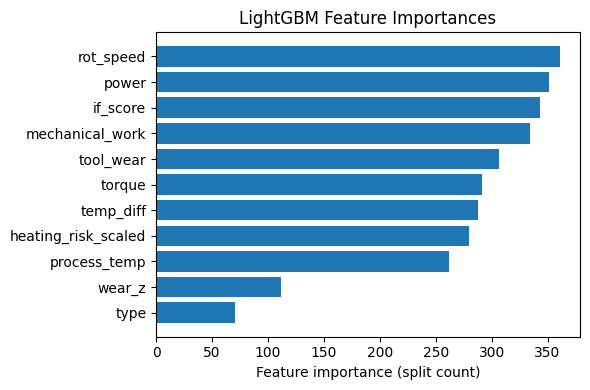

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you’ve just trained:
# clf.fit(X_tr, y_tr)

# 1) Grab importances and feature names
imp_vals = clf.feature_importances_
imp_names = X_tr.columns

# 2) Build a DataFrame and sort
imp_df = pd.DataFrame({
    'feature': imp_names,
    'importance': imp_vals
}).sort_values('importance', ascending=False)

print(imp_df)

# 3) (Optional) Quick bar‐plot
plt.figure(figsize=(6,4))
plt.barh(imp_df['feature'], imp_df['importance'])
plt.gca().invert_yaxis()
plt.xlabel("Feature importance (split count)")
plt.title("LightGBM Feature Importances")
plt.tight_layout()
plt.show()


In [11]:
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import RobustScaler

# Prepare storage
iso_scores = np.zeros(len(df))

# Loop over tool types
for t in df['type'].unique():
    idx = df['type'] == t
    X_t = df.loc[idx, features]              # features is your list of columns
    scaler = RobustScaler().fit(X_t)         # scale per-type
    X_t_s = scaler.transform(X_t)

    iso = IsolationForest(
        contamination=0.05,
        n_estimators=500,
        max_features=0.5,
        random_state=42
    ).fit(X_t_s)

    # Higher score = more “normal,” so we invert
    scores_t = -iso.decision_function(X_t_s)
    iso_scores[idx] = scores_t

# Add back to df
df['if_score_grouped'] = iso_scores


In [12]:
# drop if_score
df.drop(columns=['if_score'], inplace=True)

In [13]:
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
# 1) Compute IF score on the entire dataset
df['if_score'] = -iso.decision_function(df[features])

# 2) Rebuild X/y with the extra column
X2 = df[features + ['if_score_grouped']]
y2 = df['machine_failure']

# 3) Split & retrain
X_tr, X_te, y_tr, y_te = train_test_split(
    X2, y2, test_size=0.2, stratify=y2, random_state=42
)
clf = LGBMClassifier(class_weight='balanced', random_state=42)
clf.fit(X_tr, y_tr)

# 4) Evaluate
print(classification_report(y_te, clf.predict(X_te), digits=4))


[LightGBM] [Info] Number of positive: 271, number of negative: 7729
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000475 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2191
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
              precision    recall  f1-score   support

           0     0.9938    0.9953    0.9946      1932
           1     0.8615    0.8235    0.8421        68

    accuracy                         0.9895      2000
   macro avg     0.9277    0.9094    0.9183      2000
weighted avg     0.9893    0.9895    0.9894      2000



d:\predictive maintenence\venv\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(


In [15]:
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
# 1) Compute IF score on the entire dataset


# 2) Rebuild X/y with the extra column
X3 = df[features]
y3 = df['machine_failure']

# 3) Split & retrain
X_tr, X_te, y_tr, y_te = train_test_split(
    X2, y2, test_size=0.2, stratify=y2, random_state=42
)
clf = LGBMClassifier(class_weight='balanced', random_state=42)
clf.fit(X_tr, y_tr)

# 4) Evaluate
print(classification_report(y_te, clf.predict(X_te), digits=4))

[LightGBM] [Info] Number of positive: 271, number of negative: 7729
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000324 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2191
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
              precision    recall  f1-score   support

           0     0.9938    0.9953    0.9946      1932
           1     0.8615    0.8235    0.8421        68

    accuracy                         0.9895      2000
   macro avg     0.9277    0.9094    0.9183      2000
weighted avg     0.9893    0.9895    0.9894      2000



In [16]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X = df[features]               # all floats/ints
y = df['machine_failure']

X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

cb = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    # no need to pass cat_features if everything’s numeric
    random_seed=42,
    verbose=False
)
cb.fit(X_tr, y_tr)
print(classification_report(y_te, cb.predict(X_te), digits=4))


              precision    recall  f1-score   support

           0     0.9928    0.9979    0.9954      1932
           1     0.9310    0.7941    0.8571        68

    accuracy                         0.9910      2000
   macro avg     0.9619    0.8960    0.9262      2000
weighted avg     0.9907    0.9910    0.9907      2000



In [17]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve

# 1) Prepare data
features = [
    'type','process_temp','rot_speed','torque',
    'tool_wear','temp_diff','heating_risk_scaled',
    'power','wear_z','mechanical_work'
]
X = df[features]
y = df['machine_failure']

# 2) Train/Test Split
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# 3) Compute imbalance weight
scale_pos = (1 - y_tr.mean()) / y_tr.mean()  # ~28.5

# 4) Fit XGBClassifier
xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=scale_pos,
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    random_state=42
)
xgb.fit(X_tr, y_tr)

# 5) Evaluate with default 0.5 threshold
preds = xgb.predict(X_te)
probs = xgb.predict_proba(X_te)[:,1]

print("Classification Report (0.5 thresh):")
print(classification_report(y_te, preds, digits=4))
print("ROC AUC:", roc_auc_score(y_te, probs))

# 6) (Optional) Threshold tuning for best F1
prec, rec, thr = precision_recall_curve(y_te, probs)
f1_scores = 2 * (prec * rec) / (prec + rec + 1e-12)
best_idx = f1_scores.argmax()
best_thr = thr[best_idx]
print(f"\nBest F1 {f1_scores[best_idx]:.3f} at threshold {best_thr:.4f}")

# 7) Evaluate at tuned threshold
tuned_preds = (probs >= best_thr).astype(int)
print("\nClassification Report (tuned thresh):")
print(classification_report(y_te, tuned_preds, digits=4))


d:\predictive maintenence\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:47:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classification Report (0.5 thresh):
              precision    recall  f1-score   support

           0     0.9938    0.9933    0.9935      1932
           1     0.8116    0.8235    0.8175        68

    accuracy                         0.9875      2000
   macro avg     0.9027    0.9084    0.9055      2000
weighted avg     0.9876    0.9875    0.9875      2000

ROC AUC: 0.9775986481549142

Best F1 0.864 at threshold 0.8975

Classification Report (tuned thresh):
              precision    recall  f1-score   support

           0     0.9928    0.9984    0.9956      1932
           1     0.9474    0.7941    0.8640        68

    accuracy                         0.9915      2000
   macro avg     0.9701    0.8963    0.9298      2000
weighted avg     0.9913    0.9915    0.9911      2000

